In [3]:
file_path = '서울특별시 공공자전거 대여이력 정보_2506.csv'
df = pd.read_csv(file_path)
print(df.columns.tolist())

['자전거번호', '대여일시', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납대여소번호', '반납대여소명', '반납거치대', '이용시간(분)', '이용거리(M)', '생년', '성별', '이용자종류', '대여대여소ID', '반납대여소ID', '자전거구분']


In [4]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 시각화 설정
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

In [5]:
# 1 결측/특수 문자 정리 (생년 '\N' -> NaN, 성별 빈칸 -> NaN)
df['생년'] = df['생년'].replace('\\N', np.nan)  # 문자열 '\N' 처리
df['생년'] = pd.to_numeric(df['생년'], errors='coerce')

# 성별: 빈 문자열이나 공백을 NaN로
df['성별'] = df['성별'].replace('', np.nan)
df['성별'] = df['성별'].str.strip()  # 공백 제거
df['성별'] = df['성별'].replace({'': np.nan})
df['성별'] = df['성별'].replace({'M':'M','m':'M',
                                 'F':'F','f':'F'})

# 2 날짜 파싱: RENT_DT에 "2025-06-05 4:26:46 PM" 형태
# 안전하게 파싱
def parse_datetime_safe(series):
    dt = pd.to_datetime(series, format='%Y-%m-%d %I:%M:%S %p', errors='coerce')
    mask = dt.isna()
    if mask.any():
        # 24시간 포맷 시도
        dt.loc[mask] = pd.to_datetime(series[mask], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    if dt.isna().any():
        # 마지막으로 infer 시도
        dt = pd.to_datetime(series, infer_datetime_format=True, errors='coerce')
    return dt

df['대여일시_parsed'] = parse_datetime_safe(df['대여일시'])
df['반납일시_parsed'] = parse_datetime_safe(df['반납일시'])

# 3 파생변수: date, hour, weekday, age
df['date'] = df['대여일시_parsed'].dt.date
df['hour'] = df['대여일시_parsed'].dt.hour
df['weekday'] = df['대여일시_parsed'].dt.weekday  # 0=월

# age 계산: 기준연도는 RENT_DT 연도 사용(안정성 위해 RENT_DT_parsed에서 연도 추출)
df['rent_year'] = df['대여일시_parsed'].dt.year
df['age'] = df['rent_year'] - df['생년']
# age 음수나 극단값 처리
df.loc[(df['age'] < 0) | (df['age'] > 120), 'age'] = np.nan

# 4 종속변수 타입 정리
df['이용시간(분)'] = pd.to_numeric(df['이용시간(분)'], errors='coerce')
df['이용거리(M)'] = pd.to_numeric(df['이용거리(M)'], errors='coerce')

# 5 이상치/불필요 행 제거
# - USE_DST == 0 제거 (이동거리 0은 무의미한 이동으로 판단)
# - USE_MIN <= 0 제거
# - USE_MIN > 1440 제거(안전장치)
mask_valid = (
    df['이용시간(분)'].notna() &
    df['이용거리(M)'].notna() &
    (df['이용거리(M)'] > 0) &
    (df['이용시간(분)'] > 0) &
    (df['이용시간(분)'] <= 1440)
)
df_clean = df.loc[mask_valid].copy()

# 성별 결측 비율이 작다면 결측 행 제거
df_clean = df_clean[df_clean['성별'].notna()]

# 6 속도 계산: km/h (거리 m -> km, 시간 분 -> 시간)
df_clean['speed_kmh'] = df_clean['이용거리(M)'] / 1000.0 / (df_clean['이용시간(분)'] / 60.0)

# 7 속도 이상치 진단(요약 출력)
print('전체 샘플 수:', len(df_clean))
print('속도 NaN 비율:', df_clean['speed_kmh'].isna().mean())
print('속도 > 50 count:', (df_clean['speed_kmh'] > 50).sum())
print('속도 > 100 count:', (df_clean['speed_kmh'] > 100).sum())

# 8 속도 기준 필터 적용 (권장: 제거 기준 speed_kmh > 50)
speed_cutoff = 50.0  # 이 값을 100 등으로 바꿔 민감도 실험 가능
df_clean = df_clean[df_clean['speed_kmh'] <= speed_cutoff].copy()

C:\Users\user\AppData\Local\Temp\ipykernel_15120\2245525950.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(series, infer_datetime_format=True, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_15120\2245525950.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(series, infer_datetime_format=True, errors='coerce')


전체 샘플 수: 768568
속도 NaN 비율: 0.0
속도 > 50 count: 174
속도 > 100 count: 38


  성별       n   mean_min  median_min    std_min     mean_dst  median_dst  \
0  F  286127  25.521199        14.0  28.618357  2823.692227     1667.04   
1  M  482267  22.733316        12.0  27.454623  2680.356606     1550.00   

       std_dst  
0  3301.702494  
1  3312.256567  


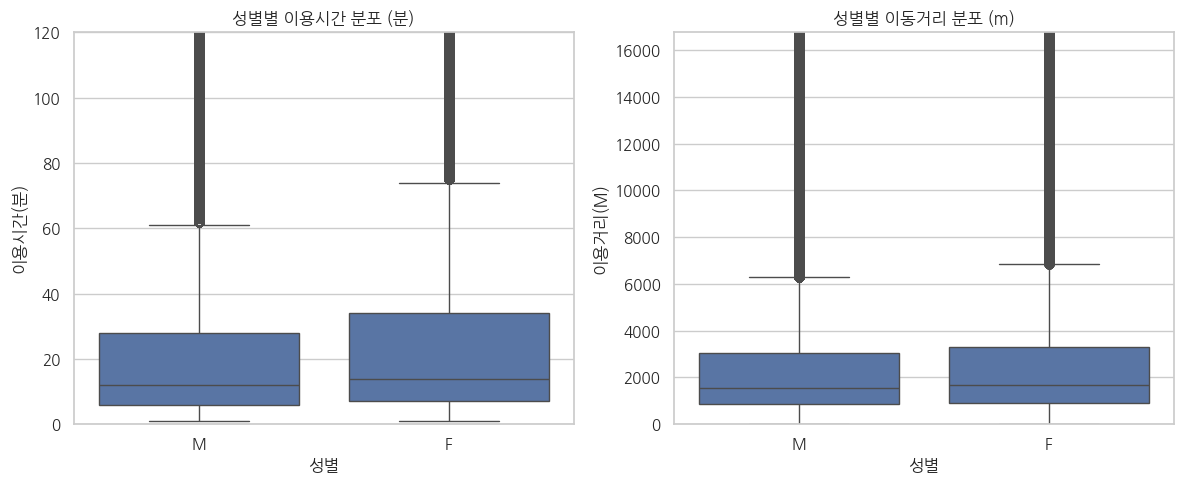

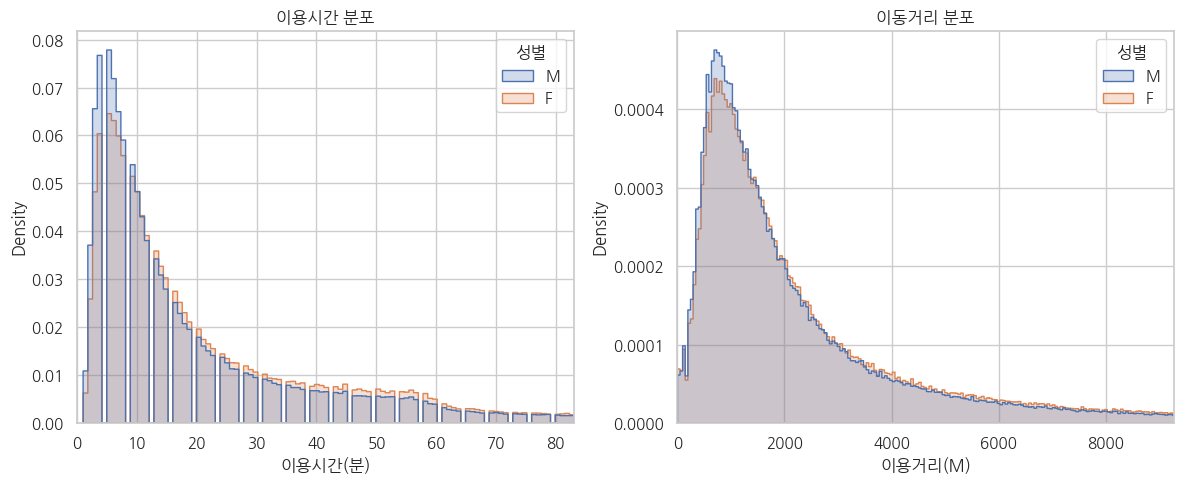

In [6]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'

# 1 기본 통계
group_stats = df_clean.groupby('성별').agg(
    n = ('이용시간(분)','count'),
    mean_min = ('이용시간(분)','mean'),
    median_min = ('이용시간(분)','median'),
    std_min = ('이용시간(분)','std'),
    mean_dst = ('이용거리(M)','mean'),
    median_dst = ('이용거리(M)','median'),
    std_dst = ('이용거리(M)','std')
).reset_index()
print(group_stats)

# 2 분포 시각화 (박스플롯 및 히스토그램)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='성별', y='이용시간(분)', data=df_clean)
plt.ylim(0, df_clean['이용시간(분)'].quantile(0.99))
plt.title('성별별 이용시간 분포 (분)')

plt.subplot(1,2,2)
sns.boxplot(x='성별', y='이용거리(M)', data=df_clean)
plt.ylim(0, df_clean['이용거리(M)'].quantile(0.99))
plt.title('성별별 이동거리 분포 (m)')
plt.tight_layout()
plt.show()

# 히스토그램(로그 변환 포함)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=df_clean, x='이용시간(분)', hue='성별', element='step', stat='density', common_norm=False)
plt.xlim(0, df_clean['이용시간(분)'].quantile(0.95))
plt.title('이용시간 분포')

plt.subplot(1,2,2)
sns.histplot(data=df_clean, x='이용거리(M)', hue='성별', element='step', stat='density', common_norm=False)
plt.xlim(0, df_clean['이용거리(M)'].quantile(0.95))
plt.title('이동거리 분포')
plt.tight_layout()
plt.show()

In [7]:
# 1) 그룹별 요약(사분위수와 IQR, 이상치 개수)
def outlier_summary(df, col, group_col='성별'):
    res = []
    for g, sub in df.groupby(group_col):
        q1 = sub[col].quantile(0.25)
        q3 = sub[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        n = len(sub)
        n_out = ((sub[col] < lower) | (sub[col] > upper)).sum()
        p_out = n_out / n
        res.append((g, n, q1, q3, iqr, lower, upper, n_out, p_out,
                    sub[col].quantile(0.99), sub[col].max()))
    return pd.DataFrame(res, columns=['성별','n','q1','q3','iqr','lower','upper','n_out','p_out','p99','max'])

print(outlier_summary(df_clean, '이용시간(분)'))
print(outlier_summary(df_clean, '이용거리(M)'))

  성별       n   q1    q3   iqr  lower  upper  n_out     p_out    p99   max
0  F  286127  7.0  34.0  27.0  -33.5   74.5  19512  0.068193  122.0  1385
1  M  482267  6.0  28.0  22.0  -27.0   61.0  39707  0.082334  118.0  1080
  성별       n      q1       q3      iqr     lower     upper  n_out     p_out  \
0  F  286127  923.46  3299.68  2376.22 -2640.870  6864.010  26656  0.093161   
1  M  482267  867.97  3031.90  2163.93 -2377.925  6277.795  46502  0.096424   

          p99       max  
0  16569.9064  82720.00  
1  16882.6716  75100.93  


C:\Users\user\AppData\Local\Temp\ipykernel_15120\936444730.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='성별', y='이용시간(분)', data=df_clean, scale='width', inner='quartile')


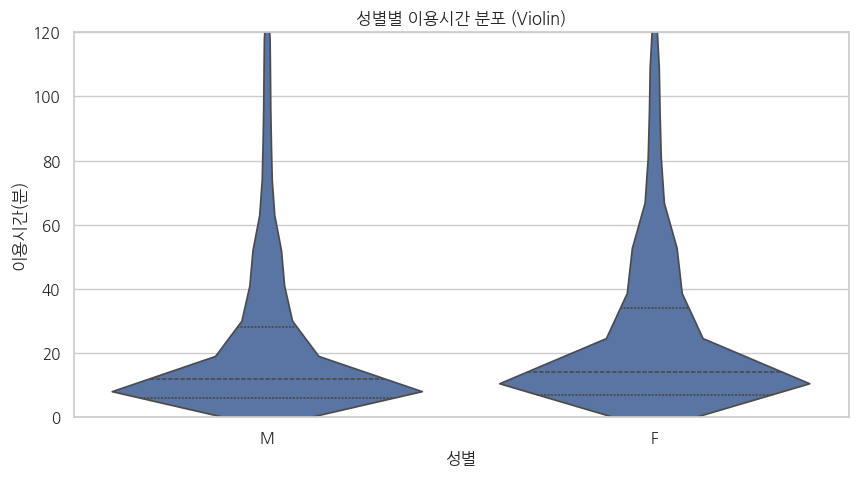

In [8]:
plt.figure(figsize=(10,5))
sns.violinplot(x='성별', y='이용시간(분)', data=df_clean, scale='width', inner='quartile')
plt.ylim(0, df_clean['이용시간(분)'].quantile(0.99))
plt.title('성별별 이용시간 분포 (Violin)')
plt.show()

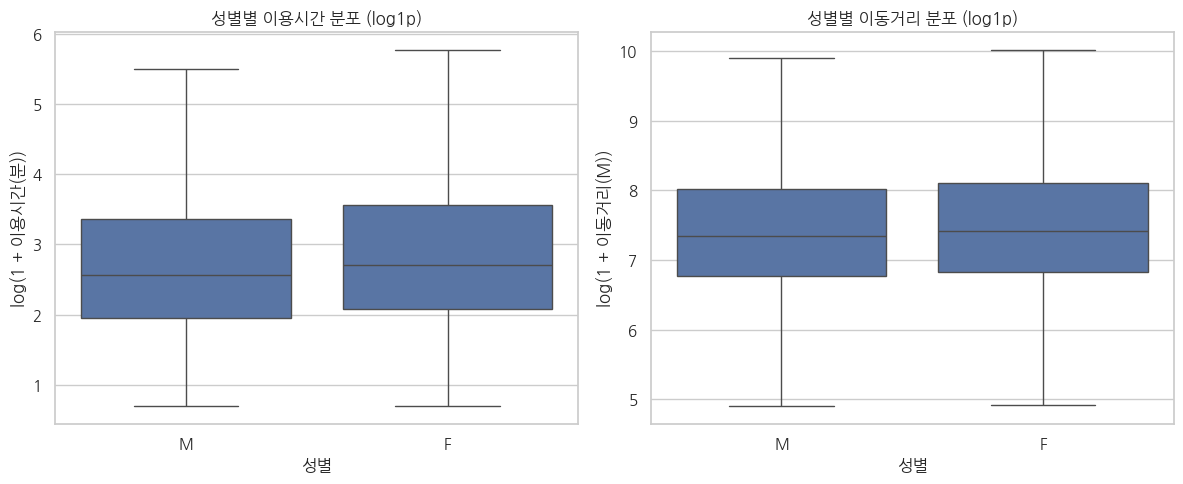

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 로그 변환 컬럼 추가
df_clean['log_이용시간'] = np.log1p(df_clean['이용시간(분)'])
df_clean['log_이동거리'] = np.log1p(df_clean['이용거리(M)'])

# 박스플롯 (로그)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x='성별', y='log_이용시간', data=df_clean, showfliers=False)
plt.title('성별별 이용시간 분포 (log1p)')
plt.ylabel('log(1 + 이용시간(분))')

plt.subplot(1,2,2)
sns.boxplot(x='성별', y='log_이동거리', data=df_clean, showfliers=False)
plt.title('성별별 이동거리 분포 (log1p)')
plt.ylabel('log(1 + 이동거리(M))')
plt.tight_layout()
plt.show()

Shapiro male p: ShapiroResult(statistic=np.float64(0.6061549490112573), pvalue=np.float64(9.108188894385445e-43))
Shapiro female p: ShapiroResult(statistic=np.float64(0.7370603989733423), pvalue=np.float64(5.121275400049763e-37))


C:\ProgramData\anaconda3\envs\sda2025\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


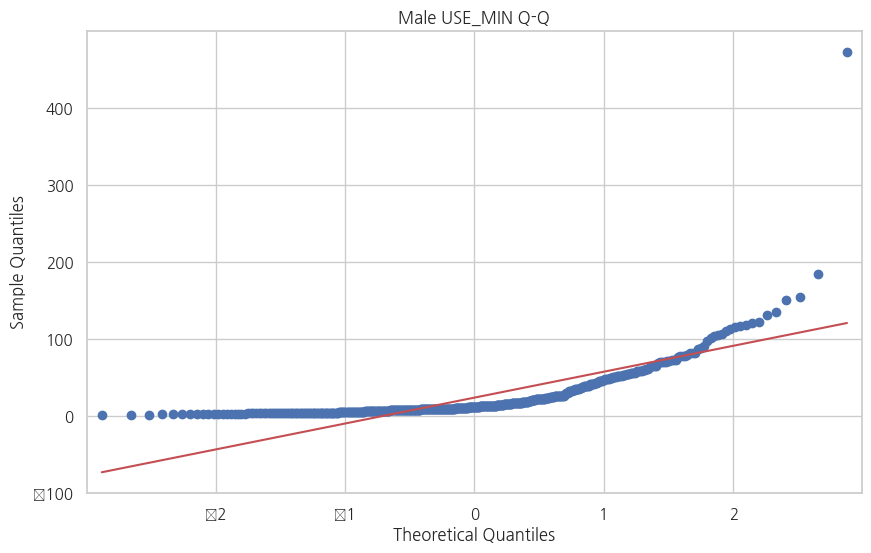

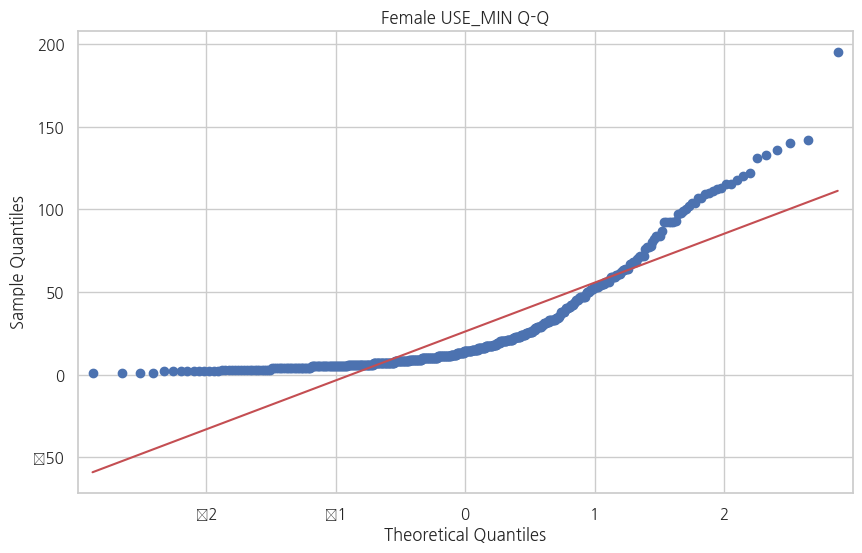

Levene p-value: 1.360504621387564e-169
Welch t-test p-value: 0.0
Mann-Whitney p-value: 0.0
USE_DST Welch p: 2.1796281843650555e-75 USE_DST Mann-Whitney p: 8.21597989436439e-208


In [10]:
# 1 데이터 분리
male = df_clean[df_clean['성별'].str.upper().str.contains('M')]['이용시간(분)'].dropna()
female = df_clean[df_clean['성별'].str.upper().str.contains('F')]['이용시간(분)'].dropna()

# 2 정규성 검사(Shapiro) — 표본이 매우 크면 Shapiro는 민감하므로 Q-Q 플롯 및 시각으로 판단
print('Shapiro male p:', stats.shapiro(male.sample(n=1000, random_state=1)) if len(male)>1000 else stats.shapiro(male))
print('Shapiro female p:', stats.shapiro(female.sample(n=1000, random_state=1)) if len(female)>1000 else stats.shapiro(female))

# Q-Q 플롯(시각)
sm.qqplot(male.sample(500, random_state=1), line='s')
plt.title('Male USE_MIN Q-Q')
plt.show()
sm.qqplot(female.sample(500, random_state=1), line='s')
plt.title('Female USE_MIN Q-Q')
plt.show()

# 3 등분산 검사(Levene)
levene_stat, levene_p = stats.levene(male, female)
print('Levene p-value:', levene_p)

# 4 평균 비교: t-test 또는 Welch / 비모수(Mann-Whitney)
# 정규성 크게 위배되고 표본 크기 매우 클 경우 중심극한정리로 t-test 사용 가능하지만 비모수도 병행
# Welch t-test (등분산 가정 불필요)
t_stat, t_p = stats.ttest_ind(male, female, equal_var=False)
print('Welch t-test p-value:', t_p)

# Mann-Whitney U (비모수)
u_stat, u_p = stats.mannwhitneyu(male, female, alternative='two-sided')
print('Mann-Whitney p-value:', u_p)

# 동일한 방식으로 이용거리(M)에 대해서도 수행
male_dst = df_clean[df_clean['성별'].str.upper().str.contains('M')]['이용거리(M)'].dropna()
female_dst = df_clean[df_clean['성별'].str.upper().str.contains('F')]['이용거리(M)'].dropna()
t_stat_dst, t_p_dst = stats.ttest_ind(male_dst, female_dst, equal_var=False)
u_stat_dst, u_p_dst = stats.mannwhitneyu(male_dst, female_dst, alternative='two-sided')
print('USE_DST Welch p:', t_p_dst, 'USE_DST Mann-Whitney p:', u_p_dst)

In [11]:
# 회귀분석 코드
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_reg = df_clean.copy()

# 1) 안전확인(중복 파생 방지)
df_reg = df_reg[df_reg['성별'].isin(['M','F'])].copy()
df_reg = df_reg[df_reg['age'].notna()].copy()
# 로그 종속(이미 생성되어 있지 않다면 생성)
if 'log_USE_MIN' not in df_reg.columns:
    df_reg['log_USE_MIN'] = np.log1p(df_reg['이용시간(분)'])
if 'log_USE_DST' not in df_reg.columns:
    df_reg['log_USE_DST'] = np.log1p(df_reg['이용거리(M)'])
# 중심화
if 'age_c' not in df_reg.columns:
    df_reg['age_c'] = df_reg['age'] - df_reg['age'].mean()

# 2) 모델식
formula = "log_USE_MIN ~ C(성별) + age_c + C(이용자종류) + C(hour) + C(weekday)"

# 3) HC3 robust OLS 적합
model = smf.ols(formula, data=df_reg).fit(cov_type='HC3')

# 4) 핵심 요약 출력 함수
def summarize_short(m, name="model"):
    print(f"--- {name} 핵심 요약 ---")
    print(f"N = {int(m.nobs):,}")
    print(f"R-squared = {m.rsquared:.4f}, Adj. R-squared = {m.rsquared_adj:.4f}\n")
    # 주요 계수 출력(성별, age, interaction 여부 확인)
    terms = []
    # 성별 계수(모델 표기: C(성별)[T.M] 형태일 수 있음)
    for t in m.params.index:
        if t.startswith('C(성별)') or t in ['age_c', 'C(성별)[T.M]', 'C(성별)[T.F]']:
            terms.append(t)
    # 보장적으로 age_c 포함
    if 'age_c' not in terms and 'age_c' in m.params.index:
        terms.append('age_c')
    # 정리해서 출력
    rows = []
    ci = m.conf_int()
    for t in terms:
        if t in m.params.index:
            coef = m.params[t]
            se = m.bse[t]
            p = m.pvalues[t]
            ci_low, ci_high = ci.loc[t]
            pct = np.expm1(coef) * 100  # 로그모형일 때 대략적 % 변화
            rows.append((t, coef, se, p, ci_low, ci_high, pct))
    if rows:
        dfc = pd.DataFrame(rows, columns=['term','coef','se','pvalue','ci_low','ci_high','pct_change_%'])
        # 정렬: 성별 먼저
        dfc = dfc.sort_values('term')
        print(dfc.to_string(index=False, float_format='{:,.4f}'.format))
    else:
        print("관심 항목(성별/age)이 모델에 없습니다.")
    # 잔차 요약
    resid = m.resid
    print("\n잔차 요약: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
        resid.mean(), resid.std(), resid.min(), resid.max()))
    print("-------------------------\n")

# 5) 요약 출력 (HC3)
summarize_short(model, "OLS (로그 종속, HC3)")

# 6) 군집 표준오차 (대여소별)이 가능하면 적용하고 핵심만 출력
station_col = None
for cand in ['대여대여소ID', '대여대여소번호', 'RENT_STATION_ID']:
    if cand in df_reg.columns:
        station_col = cand
        break

if station_col is not None:
    model_cluster = smf.ols(formula, data=df_reg).fit(cov_type='cluster', cov_kwds={'groups': df_reg[station_col]})
    summarize_short(model_cluster, f"OLS (로그, cluster by {station_col})")
else:
    print("대여소 컬럼이 없어 cluster SE 미적용 (대여대여소ID 컬럼 확인 필요).")

--- OLS (로그 종속, HC3) 핵심 요약 ---
N = 721,231
R-squared = 0.0539, Adj. R-squared = 0.0539

      term    coef     se  pvalue  ci_low  ci_high  pct_change_%
C(성별)[T.M] -0.1320 0.0022  0.0000 -0.1364  -0.1276      -12.3634
     age_c  0.0069 0.0001  0.0000  0.0068   0.0071        0.6972

잔차 요약: mean=-0.0000, std=0.9194, min=-2.9247, max=4.7420
-------------------------

--- OLS (로그, cluster by 대여대여소ID) 핵심 요약 ---
N = 721,231
R-squared = 0.0539, Adj. R-squared = 0.0539

      term    coef     se  pvalue  ci_low  ci_high  pct_change_%
C(성별)[T.M] -0.1320 0.0041  0.0000 -0.1401  -0.1239      -12.3634
     age_c  0.0069 0.0002  0.0000  0.0065   0.0074        0.6972

잔차 요약: mean=-0.0000, std=0.9194, min=-2.9247, max=4.7420
-------------------------



In [12]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# 1) 그룹별 요약표 (성별별 count, mean, se) - 이용시간 및 이용거리 포함
report_table = df_clean.groupby('성별').agg(
    n_time = ('이용시간(분)', 'count'),
    mean_time = ('이용시간(분)', 'mean'),
    se_time = ('이용시간(분)', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    n_dist = ('이용거리(M)', 'count'),
    mean_dist = ('이용거리(M)', 'mean'),
    se_dist = ('이용거리(M)', lambda x: x.std(ddof=1) / np.sqrt(len(x)))
).reset_index()

print(report_table)

# 2) 그룹별 시리즈 준비 (정확 비교)
male_time = df_clean[df_clean['성별'] == 'M']['이용시간(분)'].dropna().astype(float)
female_time = df_clean[df_clean['성별'] == 'F']['이용시간(분)'].dropna().astype(float)

male_dist = df_clean[df_clean['성별'] == 'M']['이용거리(M)'].dropna().astype(float)
female_dist = df_clean[df_clean['성별'] == 'F']['이용거리(M)'].dropna().astype(float)

# 3) Cohen's d 함수 (pooled standard deviation)
def cohens_d(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    # pooled standard deviation (unbiased)
    pooled_sd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / (nx + ny - 2))
    return (x.mean() - y.mean()) / pooled_sd

d_time = cohens_d(male_time, female_time)
d_dist = cohens_d(male_dist, female_dist)

print(f"Cohen's d (이용시간(분), M - F): {d_time:.4f}")
print(f"Cohen's d (이용거리(M), M - F): {d_dist:.4f}")

  성별  n_time  mean_time   se_time  n_dist    mean_dist   se_dist
0  F  286127  25.521199  0.053501  286127  2823.692227  6.172463
1  M  482267  22.733316  0.039534  482267  2680.356606  4.769581
Cohen's d (이용시간(분), M - F): -0.0999
Cohen's d (이용거리(M), M - F): -0.0433


C:\Users\user\AppData\Local\Temp\ipykernel_15120\3448509785.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_reg.groupby('age_group')['이용시간(분)'].agg(n='count', mean='mean', std='std').reset_index()


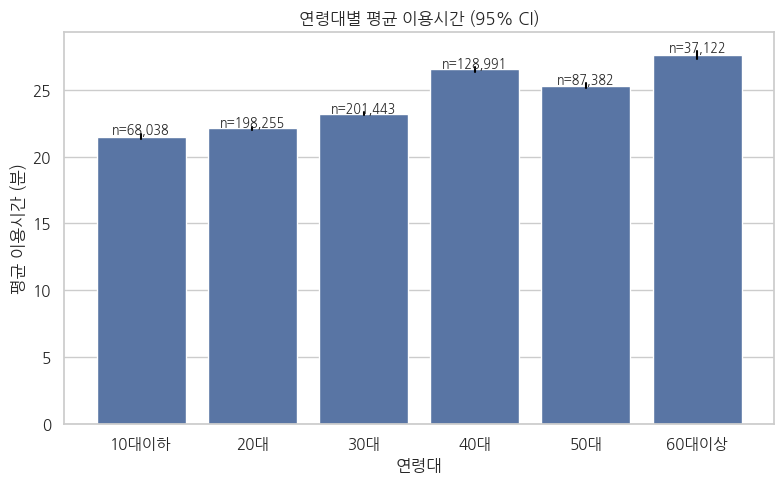

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# df_reg: 이미 전처리된 데이터프레임 (age, 이용시간(분) 존재)
# 연령대 생성
bins = [0, 19, 29, 39, 49, 59, 200]
labels = ['10대이하','20대','30대','40대','50대','60대이상']
df_reg['age_group'] = pd.cut(df_reg['age'], bins=bins, labels=labels, right=True)

# 그룹별 통계
grp = df_reg.groupby('age_group')['이용시간(분)'].agg(n='count', mean='mean', std='std').reset_index()
grp = grp[grp['n']>0]
grp['se'] = grp['std'] / np.sqrt(grp['n'])
grp['ci_low'] = grp['mean'] - 1.96 * grp['se']
grp['ci_high'] = grp['mean'] + 1.96 * grp['se']

# 플롯
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='mean', data=grp, color='#4C72B0', capsize=0.1)
# 오차막대 직접 그리기
for i, row in grp.iterrows():
    plt.plot([i, i], [row['ci_low'], row['ci_high']], color='black', linewidth=1.5)
# 샘플수 텍스트
for i, row in grp.iterrows():
    plt.text(i, row['mean'] + row['se']*1.5, f"n={int(row['n']):,}", ha='center', fontsize=9)
plt.xlabel('연령대')
plt.ylabel('평균 이용시간 (분)')
plt.title('연령대별 평균 이용시간 (95% CI)')
plt.tight_layout()
plt.show()